# Cleaning Data

## About the data
In this notebook, we will using daily temperature data from the [National Centers for Environmental Information (NCEI) API](https://www.ncdc.noaa.gov/cdo-web/webservices/v2). We will use the Global Historical Climatology Network - Daily (GHCND) dataset; see the documentation [here](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf).

This data was collected from the LaGuardia Airport station in New York City for October 2018. It contains:
- the daily minimum temperature (`TMIN`)
- the daily maximum temperature (`TMAX`)
- the daily average temperature (`TAVG`)

*Note: The NCEI is part of the National Oceanic and Atmospheric Administration (NOAA) and, as you can see from the URL for the API, this resource was created when the NCEI was called the NCDC. Should the URL for this resource change in the future, you can search for "NCEI weather API" to find the updated one.*

In addition, we will be using S&P 500 stock market data (obtained using the [`stock_analysis`](https://github.com/stefmolin/stock-analysis) package we will build in chapter 7) and data for bitcoin for 2017 through 2018. For the first edition, the bitcoin data was collected from CoinMarketCap using the `stock_analysis` package; however, changes in the website led to the necessity of changing the data source to Yahoo! Finance. The bitcoin data that was collected before the CoinMarketCap website change should be equivalent to the historical data that can be viewed on [this](https://coinmarketcap.com/currencies/bitcoin/historical-data/) page.

## Setup
We need to import `pandas` and read in the temperature data to get started:

In [37]:
import pandas as pd

df = pd.read_csv('data/nyc_temperatures.csv')
df.head()

,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
1,2018-10-01T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2,2018-10-01T00:00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
3,2018-10-02T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
4,2018-10-02T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


## Renaming Columns
We start out with the following columns:

In [38]:
df.columns

Index(['date', 'datatype', 'station', 'attributes', 'value'], dtype='object')

We want to rename the `value` column to indicate it contains the temperature in Celsius and the `attributes` column to say `flags` since each value in the comma-delimited string is a different flag about the data collection. For this task, we use the `rename()` method and pass in a dictionary mapping the column names to their new names. We pass `inplace=True` to change our original dataframe instead of getting a new one back:

In [39]:
df.rename(
    columns={
        'value': 'temp_C',
        'attributes': 'flags'
    }, inplace=True
)

Those columns have been successfully renamed:

In [40]:
df.columns

Index(['date', 'datatype', 'station', 'flags', 'temp_C'], dtype='object')

We can also perform string operations on the column names with `rename()`:

In [41]:
df.rename(str.upper, axis='columns').columns

Index(['DATE', 'DATATYPE', 'STATION', 'FLAGS', 'TEMP_C'], dtype='object')

## Type Conversion
The `date` column is not currently being stored as a `datetime`:

In [42]:
df.dtypes

date         object
datatype     object
station      object
flags        object
temp_C      float64
dtype: object

Let's perform the conversion with `pd.to_datetime()`:

In [43]:
df.loc[:,'date'] = pd.to_datetime(df.date)
df.dtypes

date        datetime64[ns]
datatype            object
station             object
flags               object
temp_C             float64
dtype: object

Now we get useful information when we use `describe()` on this column:

In [44]:
df.date.describe(datetime_is_numeric=True)

count                     93
mean     2018-10-16 00:00:00
min      2018-10-01 00:00:00
25%      2018-10-08 00:00:00
50%      2018-10-16 00:00:00
75%      2018-10-24 00:00:00
max      2018-10-31 00:00:00
Name: date, dtype: object

We can use `tz_localize()` on a `DatetimeIndex` object to convert to a desired timezone:

In [45]:
pd.date_range(start='2018-10-25', periods=2, freq='D').tz_localize('EST')

DatetimeIndex(['2018-10-25 00:00:00-05:00', '2018-10-26 00:00:00-05:00'], dtype='datetime64[ns, EST]', freq=None)

This also works with `Series`/`DataFrame` objects that have an index of type `DatetimeIndex`. Let's read in the CSV again for this example and set the `date` column to be the index and stored as a datetime:

In [46]:
eastern = pd.read_csv(
    'data/nyc_temperatures.csv', index_col='date', parse_dates=True
).tz_localize('EST')
eastern.head()

,datatype,station,attributes,value
date,,,,
2018-10-01 00:00:00-05:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
2018-10-01 00:00:00-05:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2018-10-01 00:00:00-05:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
2018-10-02 00:00:00-05:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
2018-10-02 00:00:00-05:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


We can use `tz_convert()` to convert to another timezone from there. If we convert the Eastern datetimes to UTC, they will now be at 5 AM, since `pandas` will use the offsets to convert:

In [47]:
eastern.tz_convert('UTC').head()

,datatype,station,attributes,value
date,,,,
2018-10-01 05:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
2018-10-01 05:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2018-10-01 05:00:00+00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
2018-10-02 05:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
2018-10-02 05:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


We can change the period of the index as well. We could change the period to be monthly to make it easier to aggregate later. (Aggregation will be discussed in chapter 4.)

In [48]:
eastern.tz_localize(None).to_period('M').index

PeriodIndex(['2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-

We now get a `PeriodIndex` object, which we can change back into a `DatetimeIndex` object with `to_timestamp()`:

In [49]:
eastern.tz_localize(None).to_period('M').to_timestamp().index

DatetimeIndex(['2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
      

We can use the `assign()` method for working with multiple columns at once (or creating new ones). Since our `date` column has already been converted, we need to read in the data again:

In [50]:
df = pd.read_csv('data/nyc_temperatures.csv').rename(
    columns={
        'value': 'temp_C',
        'attributes': 'flags'
    }
)

new_df = df.assign(
    date=pd.to_datetime(df.date),
    temp_F=(df.temp_C * 9/5) + 32
)
new_df.dtypes

date        datetime64[ns]
datatype            object
station             object
flags               object
temp_C             float64
temp_F             float64
dtype: object

The `date` column now has datetimes and the `temp_F` column was added:

In [51]:
new_df.head()

,date,datatype,station,flags,temp_C,temp_F
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,70.16
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,78.08
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,64.94
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,72.86
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,78.98


We can also use `astype()` to perform conversions. Let's create columns of the integer portion of the temperatures in Celsius and Fahrenheit. We will use **lambda functions** (first introduced in *Chapter 2, Working with Pandas DataFrames*), so that we can use the values being created in the `temp_F` column to calculate the `temp_F_whole` column. It is very common (and useful) to use lambda functions with `assign()`:

In [52]:
df = df.assign(
    date=lambda x: pd.to_datetime(x.date),
    temp_C_whole=lambda x: x.temp_C.astype('int'),
    temp_F=lambda x: (x.temp_C * 9/5) + 32,
    temp_F_whole=lambda x: x.temp_F.astype('int')
)

df.head()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,18,64.94,64
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


Creating categories:

In [53]:
df_with_categories = df.assign(
    station=df.station.astype('category'),
    datatype=df.datatype.astype('category')
)
df_with_categories.dtypes

date            datetime64[ns]
datatype              category
station               category
flags                   object
temp_C                 float64
temp_C_whole             int64
temp_F                 float64
temp_F_whole             int64
dtype: object

In [54]:
df_with_categories.describe(include='category')

,datatype,station
count,93,93
unique,3,1
top,TAVG,GHCND:USW00014732
freq,31,93


Our categories have no order, but this is something that `pandas` supports:

In [55]:
pd.Categorical(
    ['med', 'med', 'low', 'high'], 
    categories=['low', 'med', 'high'],
    ordered=True
)

['med', 'med', 'low', 'high']
Categories (3, object): ['low' < 'med' < 'high']

## Reordering, reindexing, and sorting
Say we want to find the days that reached the hottest temperatures in the weather data; we can sort our values by the `temp_C` column with the largest on top to find this: 

In [56]:
df[df.datatype == 'TMAX'].sort_values(by='temp_C', ascending=False).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
25,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
13,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
22,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


However, this isn't perfect because we have some ties, and they aren't sorted consistently. In the first tie between the 7th and the 10th, the earlier date comes first, but the opposite is true with the tie between the 4th and the 2nd. We can use other columns to break ties and specify how to sort each with `ascending`. Let's break ties with the date column and show earlier dates before later ones:

In [57]:
df[df.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True]).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
25,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
13,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
22,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


Notice that the index was jumbled in the past 2 results. Here, our index only stores the row number in the original data, but we may not need to keep track of that information. In this case, we can pass in `ignore_index=True` to get a new index after sorting:

In [58]:
df[df.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True], ignore_index=True).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
1,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
2,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
3,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
4,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
5,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
6,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
8,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
9,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


When just looking for the n-largest values, rather than wanting to sort all the data, we can use `nlargest()`:

In [59]:
df[df.datatype == 'TAVG'].nlargest(n=10, columns='temp_C')

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
27,2018-10-10,TAVG,GHCND:USW00014732,"H,,S,",23.8,23,74.84,74
30,2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
18,2018-10-07,TAVG,GHCND:USW00014732,"H,,S,",22.8,22,73.04,73
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
6,2018-10-03,TAVG,GHCND:USW00014732,"H,,S,",21.8,21,71.24,71
24,2018-10-09,TAVG,GHCND:USW00014732,"H,,S,",21.8,21,71.24,71
9,2018-10-04,TAVG,GHCND:USW00014732,"H,,S,",21.3,21,70.34,70
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
21,2018-10-08,TAVG,GHCND:USW00014732,"H,,S,",20.9,20,69.62,69
12,2018-10-05,TAVG,GHCND:USW00014732,"H,,S,",20.3,20,68.54,68


We use `nsmallest()` for the n-smallest values.

In [60]:
df.nsmallest(n=5, columns=['temp_C', 'date'])

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
65,2018-10-22,TMIN,GHCND:USW00014732,",,W,2400",5.6,5,42.08,42
77,2018-10-26,TMIN,GHCND:USW00014732,",,W,2400",5.6,5,42.08,42
62,2018-10-21,TMIN,GHCND:USW00014732,",,W,2400",6.1,6,42.98,42
74,2018-10-25,TMIN,GHCND:USW00014732,",,W,2400",6.1,6,42.98,42
53,2018-10-18,TMIN,GHCND:USW00014732,",,W,2400",6.7,6,44.06,44


The `sample()` method will give us rows (or columns with `axis=1`) at random. We can provide a seed (`random_state`) to make this reproducible. The index after we do this is jumbled:

In [61]:
df.sample(5, random_state=0).index

Int64Index([2, 30, 55, 16, 13], dtype='int64')

We can use `sort_index()` to order it again:

In [62]:
df.sample(5, random_state=0).sort_index().index

Int64Index([2, 13, 16, 30, 55], dtype='int64')

The `sort_index()` method can also sort columns alphabetically:

In [63]:
df.sort_index(axis=1).head()

,datatype,date,flags,station,temp_C,temp_C_whole,temp_F,temp_F_whole
0,TAVG,2018-10-01,"H,,S,",GHCND:USW00014732,21.2,21,70.16,70
1,TMAX,2018-10-01,",,W,2400",GHCND:USW00014732,25.6,25,78.08,78
2,TMIN,2018-10-01,",,W,2400",GHCND:USW00014732,18.3,18,64.94,64
3,TAVG,2018-10-02,"H,,S,",GHCND:USW00014732,22.7,22,72.86,72
4,TMAX,2018-10-02,",,W,2400",GHCND:USW00014732,26.1,26,78.98,78


This can make selection with `loc` easier for many columns:

In [64]:
df.sort_index(axis=1).head().loc[:,'temp_C':'temp_F_whole']

,temp_C,temp_C_whole,temp_F,temp_F_whole
0,21.2,21,70.16,70
1,25.6,25,78.08,78
2,18.3,18,64.94,64
3,22.7,22,72.86,72
4,26.1,26,78.98,78


We must sort the index to compare two dataframes. If the index is different, but the data is the same, they will be marked not-equal:

In [65]:
df.equals(df.sort_values(by='temp_C'))

False

Sorting the index solves this issue:

In [66]:
df.equals(df.sort_values(by='temp_C').sort_index())

True

Let's set the `date` column as our index:

In [67]:
df.set_index('date', inplace=True)
df.head()

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,18,64.94,64
2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


Now that we have an index of type `DatetimeIndex`, we can do datetime slicing and indexing. As long as we provide a date format that pandas understands, we can grab the data. To select all of 2018, we simply use `df.loc['2018']`, for the fourth quarter of 2018 we can use `df.loc['2018-Q4']`, grabbing October is as simple as using `df.loc['2018-10']`; these can also be combined to build ranges. Let's grab October 11, 2018 through October 12, 2018 (inclusive of both endpoints)&mdash;note that using `loc[]` is optional for ranges:

In [68]:
df['2018-10-11':'2018-10-12']

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
2018-10-11,TMIN,GHCND:USW00014732,",,W,2400",21.7,21,71.06,71
2018-10-12,TAVG,GHCND:USW00014732,"H,,S,",18.3,18,64.94,64
2018-10-12,TMAX,GHCND:USW00014732,",,W,2400",22.2,22,71.96,71
2018-10-12,TMIN,GHCND:USW00014732,",,W,2400",12.2,12,53.96,53


We can also use `reset_index()` to get a fresh index and move our current index into a column for safe keeping. This is especially useful if we had data, such as the date, in the index that we don't want to lose:

In [69]:
df['2018-10-11':'2018-10-12'].reset_index()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
1,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
2,2018-10-11,TMIN,GHCND:USW00014732,",,W,2400",21.7,21,71.06,71
3,2018-10-12,TAVG,GHCND:USW00014732,"H,,S,",18.3,18,64.94,64
4,2018-10-12,TMAX,GHCND:USW00014732,",,W,2400",22.2,22,71.96,71
5,2018-10-12,TMIN,GHCND:USW00014732,",,W,2400",12.2,12,53.96,53


Reindexing allows us to conform our axis to contain a given set of labels. Let's turn to the S&P 500 stock data in the `sp500.csv` file to see an example of this. Notice we only have data for trading days (weekdays, excluding holidays):

In [70]:
sp = pd.read_csv(
    'data/sp500.csv', index_col='date', parse_dates=True
).drop(columns=['adj_close'])

sp.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3770530000,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3764890000,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3761820000,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3339890000,Friday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3217610000,Monday
2017-01-10,2279.270020,2265.270020,2269.719971,2268.899902,3638790000,Tuesday
2017-01-11,2275.320068,2260.830078,2268.600098,2275.320068,3620410000,Wednesday
2017-01-12,2271.780029,2254.250000,2271.139893,2270.439941,3462130000,Thursday
2017-01-13,2278.679932,2271.510010,2272.739990,2274.639893,3081270000,Friday


If we want to look at the value of a portfolio (group of assets) that trade on different days, we need to handle the mismatch in the index. Bitcoin, for example, trades daily. If we sum up all the data we have for each day (aggregations will be covered in chapter 4, so don't fixate on this part), we get the following:

In [71]:
bitcoin = pd.read_csv(
    'data/bitcoin.csv', index_col='date', parse_dates=True
).drop(columns=['market_cap'])

# every day's closing price = S&P 500 close + Bitcoin close (same for other metrics)
portfolio = pd.concat([sp, bitcoin], sort=False).groupby(level='date').sum()

portfolio.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,1003.080000,958.700000,963.660000,998.330000,147775008,Sunday
2017-01-02,1031.390000,996.700000,998.620000,1021.750000,222184992,Monday
2017-01-03,3307.959883,3266.729883,3273.170068,3301.670078,3955698000,Tuesday
2017-01-04,3432.240068,3306.000098,3306.000098,3425.480000,4109835984,Wednesday
2017-01-05,3462.600000,3170.869951,3424.909932,3282.380000,4272019008,Thursday
2017-01-06,3328.910098,3148.000059,3285.379893,3179.179980,3691766000,Friday
2017-01-07,908.590000,823.560000,903.490000,908.590000,279550016,Saturday
2017-01-08,942.720000,887.250000,908.170000,911.200000,158715008,Sunday
2017-01-09,3189.179990,3148.709902,3186.830088,3171.729902,3359486992,Monday


It may not be immediately obvious what is wrong with the previous data, but with a visualization we can easily see the cyclical pattern of drops on the days the stock market is closed. (Don't worry about the plotting code too much, we will cover it in depth in chapters 5 and 6).

We will need to import `matplotlib` now:

In [72]:
import matplotlib.pyplot as plt # we use this module for plotting
from matplotlib.ticker import StrMethodFormatter # for formatting the axis

Now we can see why we need to reindex:

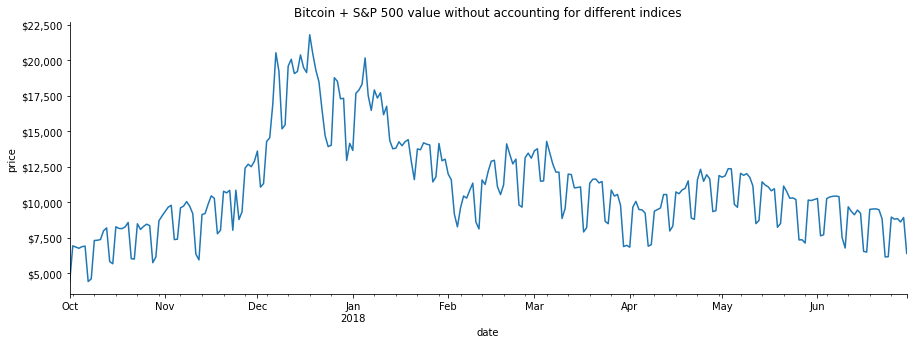

In [73]:
# plot the closing price from Q4 2017 through Q2 2018
ax = portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', figsize=(15, 5), legend=False,
    title='Bitcoin + S&P 500 value without accounting for different indices'
)

# formatting
ax.set_ylabel('price')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# show the plot
plt.show()

We need to align the index of the S&P 500 to match bitcoin in order to fix this. We will use the `reindex()` method, but by default we get `NaN` for the values that we don't have data for:

In [74]:
sp.reindex(bitcoin.index).head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-02,NaN,NaN,NaN,NaN,NaN,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,NaN,NaN,NaN,NaN,NaN,Saturday
2017-01-08,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


So now we have rows for every day of the year, but all the weekends and holidays have `NaN` values. To address this, we can specify how to handle missing values with the `method` argument. In this case, we want to forward-fill, which will put the weekend and holiday values as the value they had for the Friday (or end of trading week) before:

In [75]:
sp.reindex(bitcoin.index, method='ffill').head(10)\
    .assign(day_of_week=lambda x: x.index.day_name())

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-02,NaN,NaN,NaN,NaN,NaN,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Saturday
2017-01-08,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


To isolate the changes happening with the forward-filling, we can use the `compare()` method. It shows us the values that differ across identically-labeled dataframes (same names and same columns). Here, we can see that only weekends and holidays (Monday, January 16, 2017 was MLK day) have values forward-filled. Notice that consecutive days have the same values.

In [76]:
sp.reindex(bitcoin.index)\
    .compare(sp.reindex(bitcoin.index, method='ffill'))\
    .head(10).assign(day_of_week=lambda x: x.index.day_name())

high               low              open              close  \
           self        other self        other self        other  self   
date                                                                     
2017-01-07  NaN  2282.100098  NaN  2264.060059  NaN  2271.139893   NaN   
2017-01-08  NaN  2282.100098  NaN  2264.060059  NaN  2271.139893   NaN   
2017-01-14  NaN  2278.679932  NaN  2271.510010  NaN  2272.739990   NaN   
2017-01-15  NaN  2278.679932  NaN  2271.510010  NaN  2272.739990   NaN   
2017-01-16  NaN  2278.679932  NaN  2271.510010  NaN  2272.739990   NaN   
2017-01-21  NaN  2276.959961  NaN  2265.010010  NaN  2269.959961   NaN   
2017-01-22  NaN  2276.959961  NaN  2265.010010  NaN  2269.959961   NaN   
2017-01-28  NaN  2299.020020  NaN  2291.620117  NaN  2299.020020   NaN   
2017-01-29  NaN  2299.020020  NaN  2291.620117  NaN  2299.020020   NaN   
2017-02-04  NaN  2298.310059  NaN  2287.879883  NaN  2288.540039   NaN   

                        volume               day_of_week  
                  other   self         other              
date                                                      
2017-01-07  2276.979980    NaN  3.339890e+09    Saturday  
2017-01-08  2276.979980    NaN  3.339890e+09      Sunday  
2017-01-14  2274.639893    NaN  3.081270e+09    Saturday  
2017-01-15  2274.639893    NaN  3.081270e+09      Sunday  
2017-01-16  2274.639893    NaN  3.081270e+09      Monday  
2017-01-21  2271.310059    NaN  3.524970e+09    Saturday  
2017-01-22  2271.310059    NaN  3.524970e+09      Sunday  
2017-01-28  2294.689941    NaN  3.135890e+09    Saturday  
2017-01-29  2294.689941    NaN  3.135890e+09      Sunday  
2017-02-04  2297.419922    NaN  3.597970e+09    Saturday

This isn't perfect though. We probably want 0 for the volume traded and to put the closing price for the open, high, low, and close on the days the market is closed:

In [78]:
import numpy as np

sp_reindexed = sp.reindex(bitcoin.index).assign(
    volume=lambda x: x.volume.fillna(0), # put 0 when market is closed
    close=lambda x: x.close.fillna(method='ffill'), # carry this forward
    # take the closing price if these aren't available
    open=lambda x: np.where(x.open.isnull(), x.close, x.open),
    high=lambda x: np.where(x.high.isnull(), x.close, x.high),
    low=lambda x: np.where(x.low.isnull(), x.close, x.low)
)
sp_reindexed.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,0.000000e+00,Sunday
2017-01-02,NaN,NaN,NaN,NaN,0.000000e+00,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,2276.979980,2276.979980,2276.979980,2276.979980,0.000000e+00,Saturday
2017-01-08,2276.979980,2276.979980,2276.979980,2276.979980,0.000000e+00,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


If we create a visualization comparing the reindexed data to the first attempt, we see how reindexing helped maintain the asset value when the market was closed:

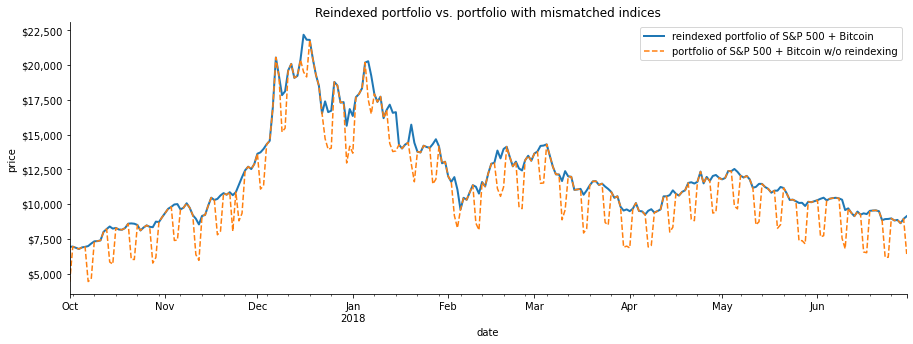

In [79]:
# every day's closing price = S&P 500 close adjusted for market closure + Bitcoin close (same for other metrics)
fixed_portfolio = sp_reindexed + bitcoin

# plot the reindexed portfolio's closing price from Q4 2017 through Q2 2018
ax = fixed_portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', label='reindexed portfolio of S&P 500 + Bitcoin', figsize=(15, 5), linewidth=2, 
    title='Reindexed portfolio vs. portfolio with mismatched indices'
)

# add line for original portfolio for comparison
portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', ax=ax, linestyle='--', label='portfolio of S&P 500 + Bitcoin w/o reindexing'
)

# formatting
ax.set_ylabel('price')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# show the plot
plt.show()

<hr>
<div>
    <a href="./2-using_the_weather_api.ipynb">
        <button>&#8592; Previous Notebook</button>
    </a>
    <a href="./4-reshaping_data.ipynb">
        <button style="float: right;">Next Notebook &#8594;</button>
    </a>
</div>
<hr>